# Homework 1

## Data for ML4P, Problem Set 1

### Author:
- **David W. Hogg** (NYU)

### Rules:
- You can copy and edit this notebook, but you are not permitted to modify (in any way) the function `make_data()`. If you want to try your code out on other data, make a new function with a new name!

In [1]:
import numpy as np
import pylab as plt

In [2]:
def make_data(seed=17, N=2**12, M=2**16, tiny=0.1):
    rng = np.random.default_rng(seed)
    latent_y = rng.uniform(size=N)
    X = rng.normal(size=(N, M)) + tiny * rng.normal(size=M)[None, :] ** 3 * latent_y[:, None] ** 1.5
    scales, shifts = 100. * rng.normal(size=M) ** 3, 100. * rng.normal(size=M) ** 3
    X *= scales[None, :]
    X += shifts[None, :]
    Y = latent_y + 0.02 * rng.normal(size=N)
    si = np.argsort(Y)
    return X[si], Y[si]

In [3]:
X, Y = make_data()
N, M = X.shape
assert(len(Y) == N)
print("feature shape", N, "by", M)

feature shape 4096 by 65536


Text(0, 0.5, 'label $Y$')

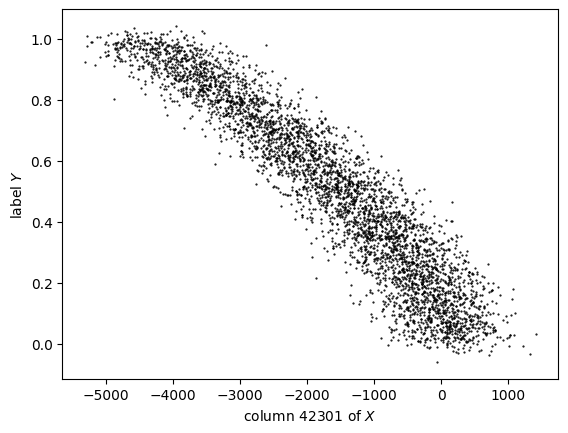

In [4]:
i = 42301
plt.scatter(X[:,i], Y, s=0.3, c="k")
plt.xlabel("column {} of $X$".format(i))
plt.ylabel("label $Y$")

# Problem 1

> Copy the notebook at https://dwh.gg/ML4Pps1. This notebook generates data X, Y to be used in a linear regression. You get 4096 data points, each with one label and M=65536 features. Split your data into 2048 training points, 1024 validation points, and 1024 test points. Don’t mess that up, do it once, and stick with it! Now your tasks are the following. To complete these tasks you can either write your own linear regression code, or use a canned code. Either way, make sure that the ordinary unweighted regressions don’t have any hidden non-zero regularizations.

_contents of the linked notebook are above_

In [5]:
# train-test split
rng = np.random.default_rng(1126)
idx = rng.permutation(N)

X_tr, Y_tr = X[ idx[:2048] ],     Y[ idx[:2048] ]
X_va, Y_va = X[ idx[2048:3072] ], Y[ idx[2048:3072] ]
X_te, Y_te = X[ idx[3072:] ],     Y[ idx[3072:] ]

## 1.a

> Do ordinary unweighted linear regressions with p=2, 4, 8, 16, … and so on all the way up to the full size M of the X matrix. Plot the root-mean-squared error (RMSE) on the training set and on the validation set as a function of p. Plot it as a log-log plot. What do you observe? Do you ever do as well as you might naively think you should do?

It's not altogether clear how we should pick _which_ $p$ feature to use in each step of the our regressions. So, I'll start by computing the Pearson correlation coefficient between each feature and the labels (on the train set of course). We can order these from largest to smallest absolute value, and then use the $p$ features with largest Pearson correlation coefficients for our size-$p$ model.

In [6]:
pearson = np.zeros(M)
for i in range(M):
    pearson[i] = np.corrcoef(X_tr[:, i], Y_tr)[0, 1]
best_feats = np.argsort(np.abs(pearson))[::-1]

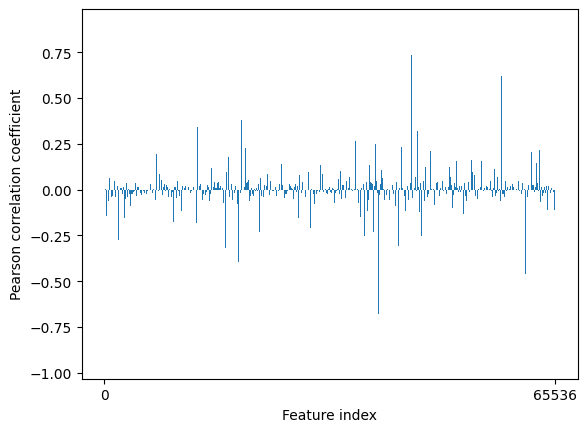

In [7]:
plt.bar(np.arange(M), pearson)
plt.xticks([0, M])
plt.xlabel("Feature index")
plt.ylabel("Pearson correlation coefficient")
plt.show()

Next we can perform the least-squares linear regressions.

In [8]:
from tqdm import tqdm

tqdm._instances.clear()

In [9]:
# Train the models
ps = 2 ** np.arange(1, 17)
models = [
    np.linalg.lstsq(X_tr[:, best_feats[:p]], Y_tr, rcond=None)[0]
    for i, p in enumerate(tqdm(ps))
]

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [01:28<00:00,  5.55s/it]


In [10]:
# Evaluate the model performance
def rms(y, x, wgt):
    return np.sqrt(np.mean(np.square(y - x @ wgt)))

rms_tr = np.zeros(len(ps))
rms_va = np.zeros(len(ps))
for i, p in enumerate(ps):
    rms_tr[i] = rms(Y_tr, X_tr[:, best_feats[:p]], models[i])
    rms_va[i] = rms(Y_va, X_va[:, best_feats[:p]], models[i])

and we can plot the root-mean-square errors on the training and validation sets of these trained models.

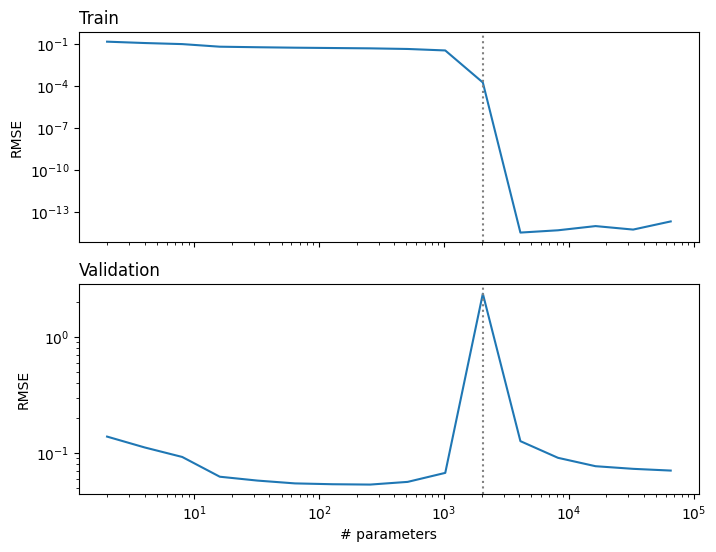

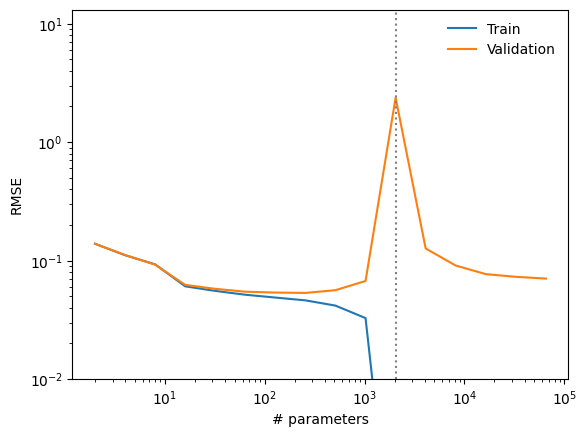

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(ps, rms_tr)
axs[1].plot(ps, rms_va)

for ax in axs.flat:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axvline(2048, ls=':', c='grey')
    
axs[0].set_ylabel('RMSE')
axs[1].set_ylabel('RMSE')
axs[0].set_title('Train', loc='left')
axs[1].set_title('Validation', loc='left')
axs[1].set_xlabel('# parameters')

plt.show()



plt.plot(ps, rms_tr, label='Train')
plt.plot(ps, rms_va, label='Validation')
plt.axvline(2048, ls=':', c='grey')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, None)
plt.legend(frameon=False)
plt.ylabel('RMSE')
plt.xlabel('# parameters')
plt.show()

We see that for small numbers of parameters, the train and validation performance improve together. However, as $p$ approaches $N$, the validation error diverges. For super large $p$, the validation error comes back down to values close to the underparameterized performance, but it doesn't quite best it. Basically for all numbers of parameters gerater than 1024, we have enough model complexity to exactly fit every data point, hence the incredibly small train RMSE values in that régime.

## 1.b

> What are the most important features (columns of X) in your best (in terms of validation-set RMSE) $p<N$ and best $p>N$ ordinary regressions? Are they features with big correlation coefficients against the Y values?

First, we need to identify the best under- and over-parameterized regressions.

In [12]:
best_under = (np.arange(16)[ps < 2048])[np.argmin(rms_va[ps < 2048])]
best_over  = (np.arange(16)[ps > 2048])[np.argmin(rms_va[ps > 2048])]

print("Best underparameterized model: p =", ps[best_under])
print("    RMSE on val:", rms_va[best_under])
print("Best overparameterized model:  p =", ps[best_over])
print("    RMSE on val:", rms_va[best_over])

Best underparameterized model: p = 256
    RMSE on val: 0.053381921995399914
Best overparameterized model:  p = 65536
    RMSE on val: 0.07051438146695287


"Importance" of a feature is hard to quantify, but I'll take the size of the corresponding weight as a metric of importance for now. Let's compare these to the correlation coefficients on the validation set.

In [13]:
pearson_va = np.zeros(M)
for i in range(M):
    pearson_va[i] = np.corrcoef(X_va[:, i], Y_va)[0, 1]

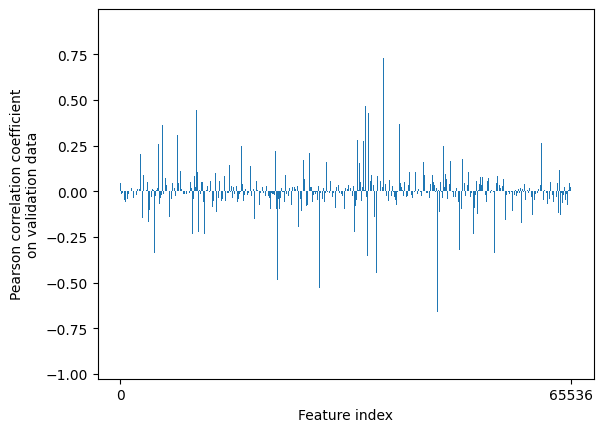

In [14]:
plt.bar(np.arange(M), pearson_va)
plt.xticks([0, M])
plt.xlabel("Feature index")
plt.ylabel("Pearson correlation coefficient\non validation data")
plt.show()

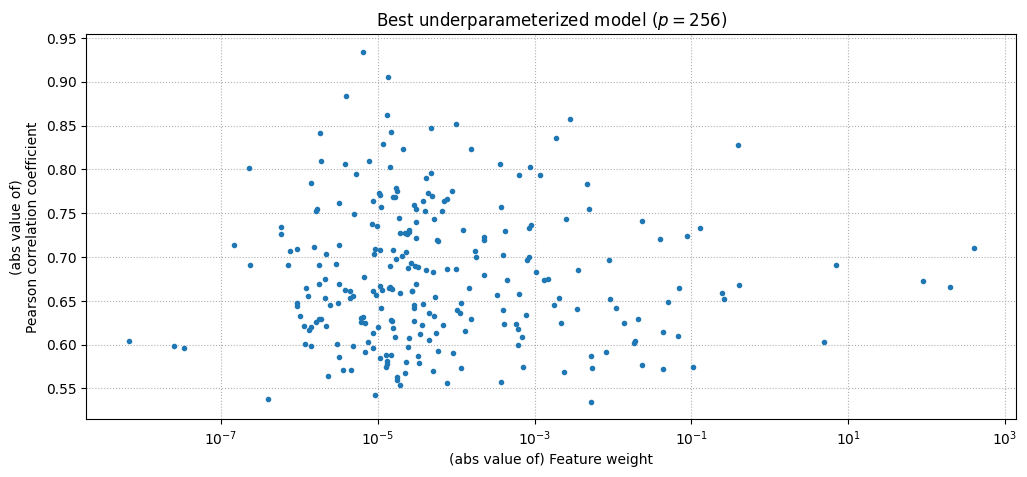

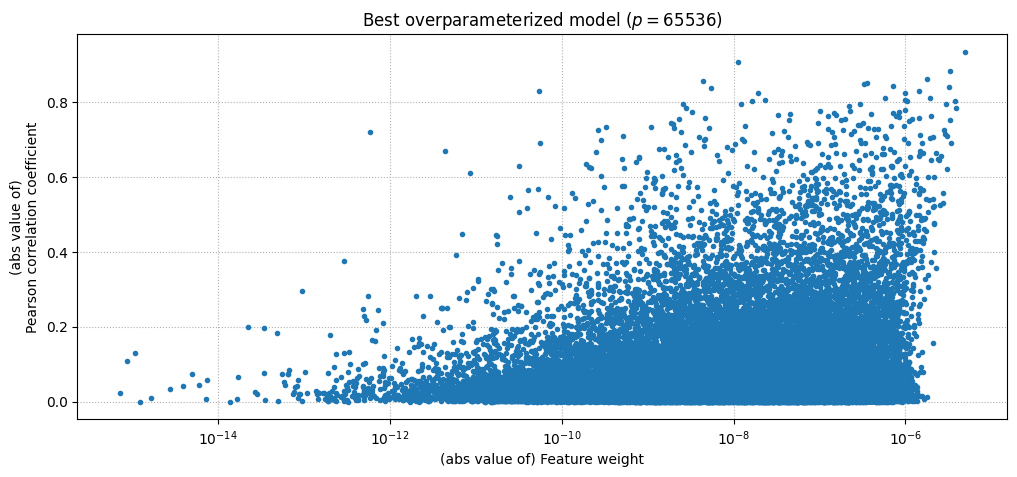

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(np.abs(models[best_under]), np.abs(pearson_va[best_feats[:ps[best_under]]]), '.')
plt.xlabel('(abs value of) Feature weight')
plt.ylabel('(abs value of)\nPearson correlation coefficient')
plt.title(f'Best underparameterized model ($p = {ps[best_under]}$)')
plt.xscale('log')
plt.grid(ls=':')
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(np.abs(models[best_over]), np.abs(pearson_va[best_feats[:ps[best_over]]]), '.')
plt.xlabel('(abs value of) Feature weight')
plt.ylabel('(abs value of)\nPearson correlation coefficient')
plt.title(f'Best overparameterized model ($p = {ps[best_over]}$)')
plt.xscale('log')
plt.grid(ls=':')
plt.show()

There doesn't appear to be the expected correlation in the underparameterized model. In the overparameterized model, there _does_ seem to be a small correlation, as large Pearson value does seem to be a predictor for large feature weight. However, the inverse isn't true: there are plenty of features with large weights that have next to zero correlation.

This all begs the question: Is the feature weight even a reasonable thing to look at? Maybe, but only if all the data have features which are of similar magnitudes. Is that the case?

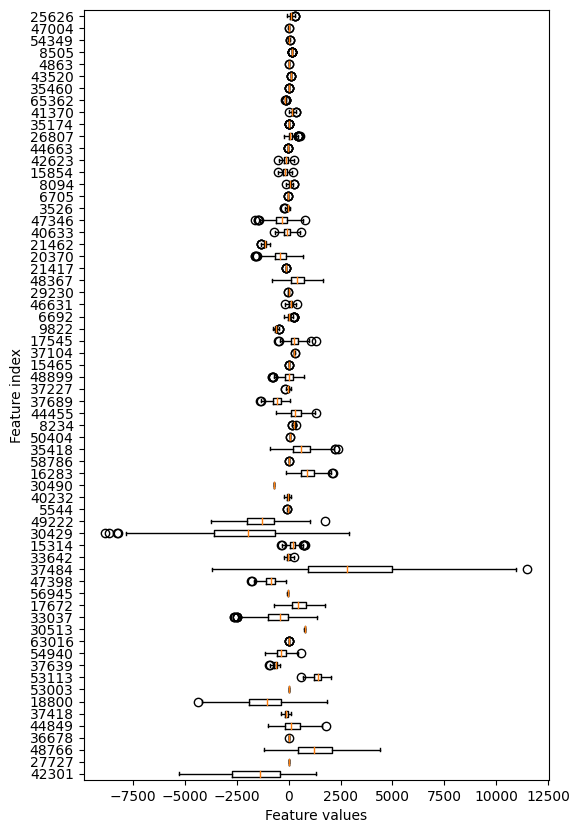

In [16]:
n_feat = 64
plt.figure(figsize=(6, 10))
plt.boxplot(X_tr[:, best_feats[:n_feat]], vert=False)
plt.yticks(np.arange(n_feat) + 1, best_feats[:n_feat])
plt.ylabel('Feature index')
plt.xlabel('Feature values')
plt.show()

The features have completely different ranges in magnitudes, so the weight value isn't a reliable indicator of importance. We might have guessed this.

## 1.c

> Do your answers to either question change if you re-scale the X data before you start such that every one of the M features has zero mean and unit variance? If they do change, which ones change, and why?

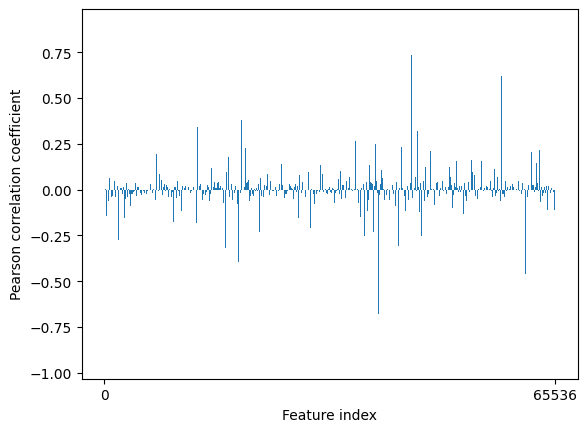

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [01:31<00:00,  5.70s/it]


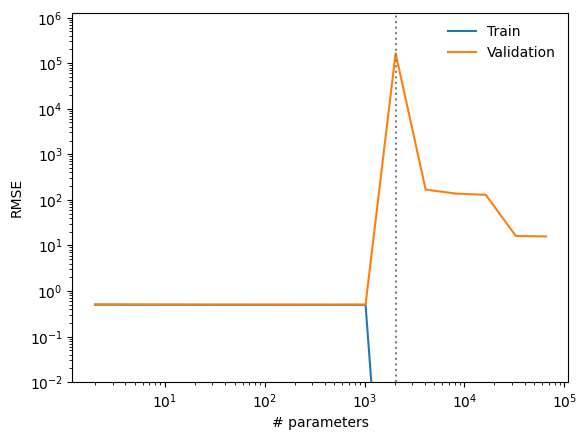

Best underparameterized model: p = 256
Best overparameterized model:  p = 65536


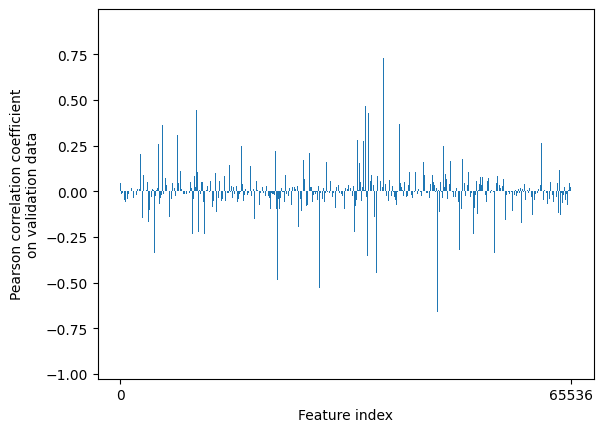

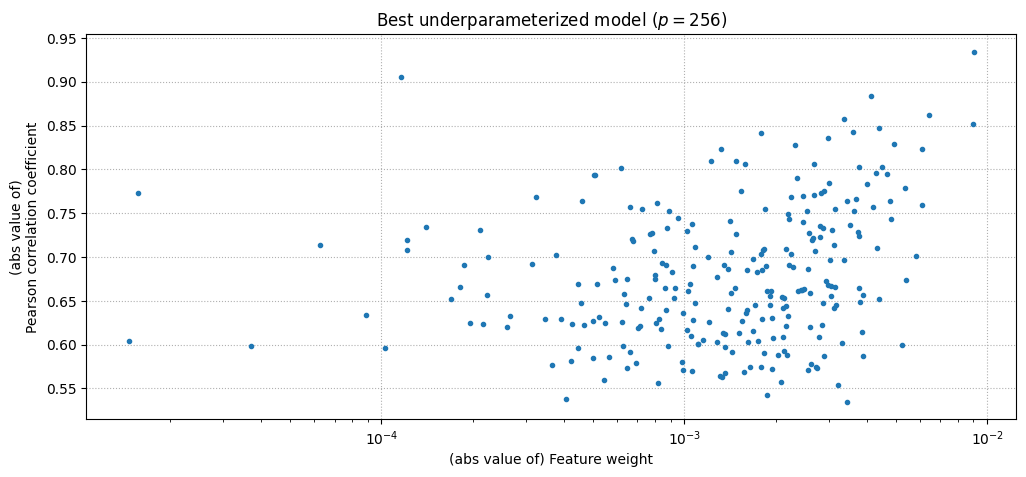

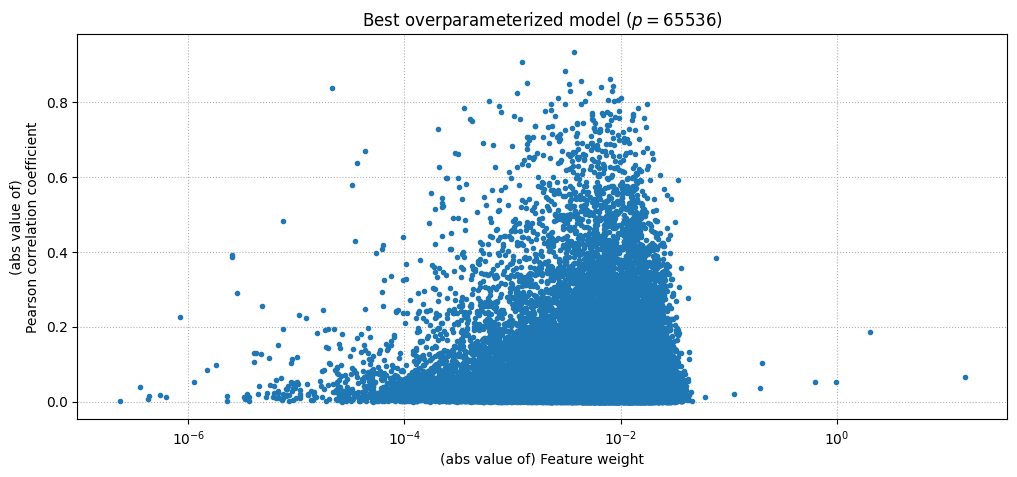

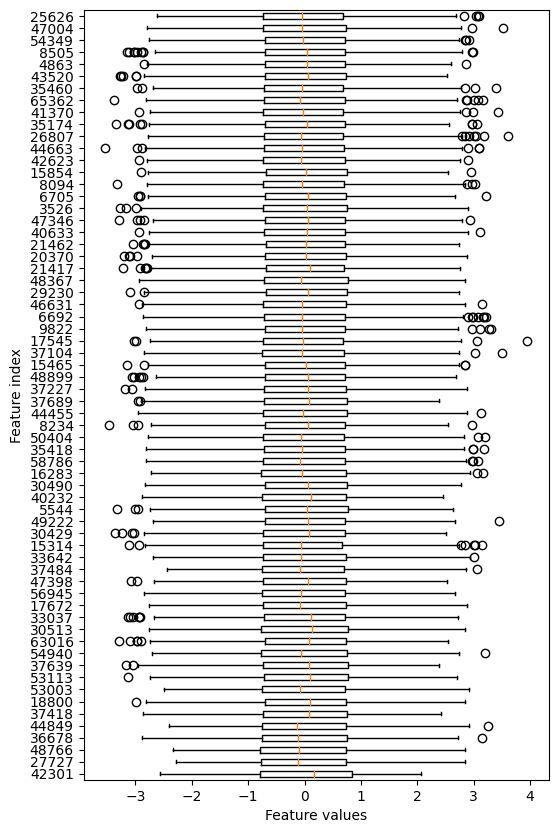

In [17]:
def redo_analysis(X_tr, X_va):
    pearson = np.zeros(M)
    for i in range(M):
        pearson[i] = np.corrcoef(X_tr[:, i], Y_tr)[0, 1]
    best_feats = np.argsort(np.abs(pearson))[::-1]
    
    
    plt.bar(np.arange(M), pearson)
    plt.xticks([0, M])
    plt.xlabel("Feature index")
    plt.ylabel("Pearson correlation coefficient")
    plt.show()
    
    
    # Train the models
    ps = 2 ** np.arange(1, 17)
    models = [
        np.linalg.lstsq(X_tr[:, best_feats[:p]], Y_tr, rcond=None)[0]
        for i, p in enumerate(tqdm(ps))
    ]
    
    
    # Evaluate the model performance
    def rms(y, x, wgt):
        return np.sqrt(np.mean(np.square(y - x @ wgt)))

    rms_tr = np.zeros(len(ps))
    rms_va = np.zeros(len(ps))
    for i, p in enumerate(ps):
        rms_tr[i] = rms(Y_tr, X_tr[:, best_feats[:p]], models[i])
        rms_va[i] = rms(Y_va, X_va[:, best_feats[:p]], models[i])


    plt.plot(ps, rms_tr, label='Train')
    plt.plot(ps, rms_va, label='Validation')
    plt.axvline(2048, ls=':', c='grey')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-2, None)
    plt.legend(frameon=False)
    plt.ylabel('RMSE')
    plt.xlabel('# parameters')
    plt.show()
    
    
    best_under = (np.arange(16)[ps < 2048])[np.argmin(rms_va[ps < 2048])]
    best_over  = (np.arange(16)[ps > 2048])[np.argmin(rms_va[ps > 2048])]

    print("Best underparameterized model: p =", ps[best_under])
    print("Best overparameterized model:  p =", ps[best_over])
    
    
    pearson_va = np.zeros(M)
    for i in range(M):
        pearson_va[i] = np.corrcoef(X_va[:, i], Y_va)[0, 1]
    
    
    plt.bar(np.arange(M), pearson_va)
    plt.xticks([0, M])
    plt.xlabel("Feature index")
    plt.ylabel("Pearson correlation coefficient\non validation data")
    plt.show()
    
    
    plt.figure(figsize=(12, 5))
    plt.plot(np.abs(models[best_under]), np.abs(pearson_va[best_feats[:ps[best_under]]]), '.')
    plt.xlabel('(abs value of) Feature weight')
    plt.ylabel('(abs value of)\nPearson correlation coefficient')
    plt.title(f'Best underparameterized model ($p = {ps[best_under]}$)')
    plt.xscale('log')
    plt.grid(ls=':')
    plt.show()


    plt.figure(figsize=(12, 5))
    plt.plot(np.abs(models[best_over]), np.abs(pearson_va[best_feats[:ps[best_over]]]), '.')
    plt.xlabel('(abs value of) Feature weight')
    plt.ylabel('(abs value of)\nPearson correlation coefficient')
    plt.title(f'Best overparameterized model ($p = {ps[best_over]}$)')
    plt.xscale('log')
    plt.grid(ls=':')
    plt.show()
    
    
    n_feat = 64
    plt.figure(figsize=(6, 10))
    plt.boxplot(X_tr[:, best_feats[:n_feat]], vert=False)
    plt.yticks(np.arange(n_feat) + 1, best_feats[:n_feat])
    plt.ylabel('Feature index')
    plt.xlabel('Feature values')
    plt.show()
    
    
    
X_tr_rescale = (X_tr - X_tr.mean(0)) / X_tr.std(0)
X_va_rescale = (X_va - X_va.mean(0)) / X_va.std(0)
redo_analysis(X_tr_rescale, X_va_rescale)

Strangely, now performance seems almost entirely stagnant in the underparameterized regime, and it's not quite as good as before.

The Pearson correlation coefficients appear unaffected, as they should.

There is now much more of a semblance of correlation between Pearson and feature weights in the underparameterized regime, which is what we might have expected and is encouraging to see. In the overparameterized regime, though, things aren't very different. High Pearson appears to be a predictor for high feature weight, but not the other way around. And now the absolute highest weights are given to low-correlation features, unlike before.

## 1.d

> Can you improve your validation-set RMSE by setting p=M (that is, using all features) but adding in an L2 (ridge) regularization? What about an L1 (LASSO) regularization?). In the best L1 case, how many non-zero features do you find? Are your most important features from above among these non-zero features?

Let's do this with scikit-learn.

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

First, let's retrain OLS with sklearn to see if it performs any differently than the np.linalg.lstsq model.

In [19]:
lstsq = LinearRegression().fit(X_tr, Y_tr)

In [20]:
def rms_sklearn(model, x, y):
    y_hat = model.predict(x)
    return np.sqrt(np.mean(np.square(y - y_hat)))

print(f"RMS_train: {rms_sklearn(lstsq, X_tr, Y_tr):.4e}")
print(f"RMS_val:   {rms_sklearn(lstsq, X_va, Y_va):.4e}")

RMS_train: 2.0077e-15
RMS_val:   7.0503e-02


...which exactly matches the performance we saw before.

Now, Ridge and Lasso regression.

I'm going to train several models using different regularization strengths (`alpha`) and we'll just take the one that performs the best. Since now we're fitting a hyperparameter based on the validation data, the validation set is no longer a true held-out set, so it's a good thing we still have the test set in our back pocket to ensure we haven't overfit. We'll check that later.

In [23]:
# playing with this shows no effect on validation RMS with alpha < 1e7
ridge_alphas = [1e7, 1e8, 1e9, 1e10, 1e11, 1e12]
ridges = []
ridge_rms_tr = []
ridge_rms_va = []

for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha).fit(X_tr, Y_tr)
    ridges.append(ridge)
    print(f"Ridge (alpha = {alpha:.0e})")
    
    _rms = rms_sklearn(ridge, X_tr, Y_tr)
    ridge_rms_tr.append( _rms )
    print(f"  RMS_train: {_rms:.4e}")
    
    _rms = rms_sklearn(ridge, X_va, Y_va)
    ridge_rms_va.append( _rms )
    print(f"  RMS_val:   {_rms:.4e}")
    

best_ridge = np.argmin(ridge_rms_va)
print(best_ridge)
print(f"Best model used alpha = {ridge_alphas[best_ridge]:.0e}")
ridge = ridges[np.argmin(ridge_rms_va)]

Ridge (alpha = 1e+07)
  RMS_train: 1.4022e-04
  RMS_val:   7.0463e-02
Ridge (alpha = 1e+08)
  RMS_train: 1.3580e-03
  RMS_val:   7.0114e-02
Ridge (alpha = 1e+09)
  RMS_train: 1.0488e-02
  RMS_val:   6.7812e-02
Ridge (alpha = 1e+10)
  RMS_train: 3.8338e-02
  RMS_val:   6.5960e-02
Ridge (alpha = 1e+11)
  RMS_train: 9.5620e-02
  RMS_val:   1.0426e-01
Ridge (alpha = 1e+12)
  RMS_train: 2.2768e-01
  RMS_val:   2.3108e-01
3
Best model used alpha = 1e+10


In [24]:
lasso_alphas = [0.5, 1, 2, 5, 10]
lassos = []
lasso_rms_tr = []
lasso_rms_va = []

for alpha in lasso_alphas:
    lasso = Lasso(alpha=alpha).fit(X_tr, Y_tr)
    lassos.append(lasso)
    print(f"Lasso (alpha = {alpha})")
    
    _rms = rms_sklearn(lasso, X_tr, Y_tr)
    lasso_rms_tr.append( _rms )
    print(f"  RMS_train: {_rms:.4e}")
    
    _rms = rms_sklearn(lasso, X_va, Y_va)
    lasso_rms_va.append( _rms )
    print(f"  RMS_val:   {_rms:.4e}")
    

best_lasso = np.argmin(lasso_rms_va)
print(best_lasso)
print(f"Best model used alpha = {lasso_alphas[best_lasso]}")
lasso = lassos[np.argmin(lasso_rms_va)]

/Users/connor/.pyenv/versions/data-science/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.360e-02, tolerance: 1.685e-02
  model = cd_fast.enet_coordinate_descent(


Lasso (alpha = 0.5)
  RMS_train: 2.0227e-02
  RMS_val:   7.3860e-02
Lasso (alpha = 1)
  RMS_train: 3.2388e-02
  RMS_val:   6.8808e-02
Lasso (alpha = 2)
  RMS_train: 4.4749e-02
  RMS_val:   6.5936e-02
Lasso (alpha = 5)
  RMS_train: 5.8109e-02
  RMS_val:   6.6982e-02
Lasso (alpha = 10)
  RMS_train: 6.5403e-02
  RMS_val:   7.0757e-02
2
Best model used alpha = 2


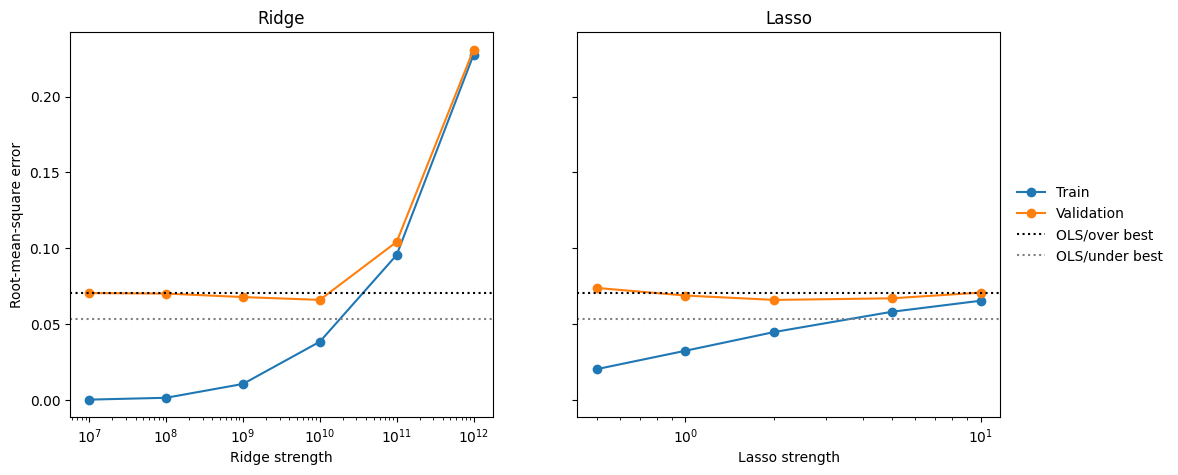

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].plot(ridge_alphas, ridge_rms_tr, '-o', label='Train')
axs[0].plot(ridge_alphas, ridge_rms_va, '-o', label='Validation')

axs[1].plot(lasso_alphas, lasso_rms_tr, '-o', label='Train')
axs[1].plot(lasso_alphas, lasso_rms_va, '-o', label='Validation')

axs[0].axhline(0.07050, c='black', ls=':', label='OLS/over best')
axs[0].axhline(0.05338, c='grey',  ls=':', label='OLS/under best')
axs[1].axhline(0.07050, c='black', ls=':', label='OLS/over best')
axs[1].axhline(0.05338, c='grey',  ls=':', label='OLS/under best')

axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))

axs[0].set_title("Ridge")
axs[1].set_title("Lasso")

axs[0].set_xlabel("Ridge strength")
axs[1].set_xlabel("Lasso strength")

axs[0].set_ylabel("Root-mean-square error")

axs[0].set_xscale('log')
axs[1].set_xscale('log')

plt.show()

With both types of regularization, we are able to eke out some validation-RMSE improvements over the best OLS/overparameterized model, but in neither case are we able to beat the underparameterized model.

585 features have nonzero weight in our best Lasso model


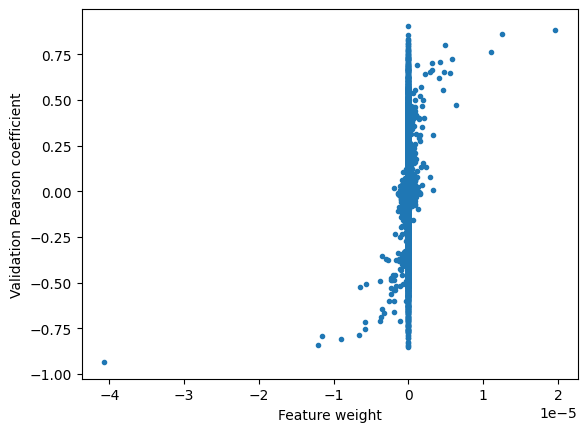

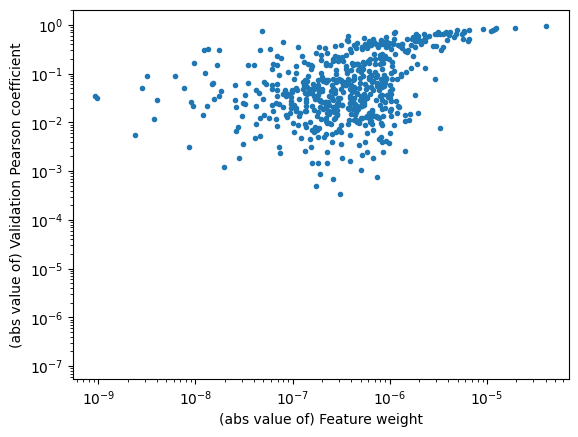

In [26]:
print(f"{np.count_nonzero(lasso.coef_)} features have nonzero weight in our best Lasso model")

plt.plot(lasso.coef_, pearson_va, '.')
plt.xlabel('Feature weight')
plt.ylabel('Validation Pearson coefficient')
plt.show()

plt.plot(np.abs(lasso.coef_), np.abs(pearson_va), '.')
plt.xlabel('(abs value of) Feature weight')
plt.ylabel('(abs value of) Validation Pearson coefficient')
plt.xscale('log')
plt.yscale('log')
plt.show()

Now the features with the largest weights (in magnitude) are also the features with the largest Pearson coefficients (in magnitude)! And generally, positive Pearson implies positive weight and vice versa.

## 1.e

> If you take the best (in terms of validation-set RMSE) $p<N$ and $p>N$ models you ever get in any of the above problem parts, but then apply them to the test data, do you do just as well on the test data, or slightly worse on the test data? If it is slightly worse, why? The data are iid.

Our best $p < N$ model is the OLS/underparameterized model. Our best $p > N$ model is the Lasso/overparameterized model with `alpha=2`.

Let's apply both to the test data and see how they fare.

In [30]:
print(f"Train RMSE values:")
print(f"  OLS/under:  {rms(Y_tr, X_tr[:, best_feats[:ps[best_under]]], models[best_under]):.4e}")
print(f"  Lasso/over: {rms_sklearn(lasso, X_tr, Y_tr):.4e}")

print(f"Validation RMSE values:")
print(f"  OLS/under:  {rms(Y_va, X_va[:, best_feats[:ps[best_under]]], models[best_under]):.4e}")
print(f"  Lasso/over: {rms_sklearn(lasso, X_va, Y_va):.4e}")

print(f"Test RMSE values:")
print(f"  OLS/under:  {rms(Y_te, X_te[:, best_feats[:ps[best_under]]], models[best_under]):.4e}")
print(f"  Lasso/over: {rms_sklearn(lasso, X_te, Y_te):.4e}")

Train RMSE values:
  OLS/under:  4.6197e-02
  Lasso/over: 4.4749e-02
Validation RMSE values:
  OLS/under:  5.3382e-02
  Lasso/over: 6.5936e-02
Test RMSE values:
  OLS/under:  5.2995e-02
  Lasso/over: 6.4419e-02


We seem to have actually been able to perform slightly better on the test set than on the validation set! But it's close enough in performance that this in itself isn't concerning. This seems to prove that the performance we've been seeing on the validation set was real generalization and not overfitting hyperparams.

## 1.f

> The data generation is not strictly linear. Try taking your best L1 features, making a new X matrix out of these, and appending all their products with themselves and each other (ie, all quadratic features). Does this create a linear regression that does better?

We _could_ take all 500ish features with nonzero weights from the Lasso regression, but I'd kind of rather not deal with $500^2$ features. So, let's take the top 256.

In [54]:
lasso_best_feats = (np.argsort(np.abs(lasso.coef_))[::-1])[:256]
print(len(lasso_best_feats))

def make_design_matrix(x):
    x_best = x[:, lasso_best_feats]
    m = len(lasso_best_feats)
    
    x_quad = np.zeros((x_best.shape[0], m * (m + 1) // 2))
    
    col = 0
    for i in range(m):
        for j in range(i, m):
            x_quad[:, col] = x_best[:, i] * x_best[:, j]
            col += 1
            
    return np.concatenate((x_best, x_quad), axis=1)

new_X_tr = make_design_matrix(X_tr)
new_X_va = make_design_matrix(X_va)
new_X_te = make_design_matrix(X_te)

print(new_X_tr.shape)
print(new_X_va.shape)
print(new_X_te.shape)

256
(2048, 33152)
(1024, 33152)
(1024, 33152)


In [55]:
new_model = np.linalg.lstsq(new_X_tr, Y_tr, rcond=None)
print(rms(Y_tr, new_X_tr, new_model[0]))
print(rms(Y_va, new_X_va, new_model[0]))
print(rms(Y_te, new_X_te, new_model[0]))

1.8740952506984128e-15
0.12069906251982566
0.12143083849168626


In [70]:
new_ridge = Ridge(alpha=1e17).fit(new_X_tr, Y_tr)
print(rms_sklearn(new_ridge, new_X_tr, Y_tr))
print(rms_sklearn(new_ridge, new_X_va, Y_va))
print(rms_sklearn(new_ridge, new_X_te, Y_te))

0.02342275512058129
0.107020994191306
0.10902236854978581


_wondering about the really high alpha? I just kept increasing it until I saw the train RMS approached the same order of magnitude as the validation, since this is the regime where the best ridge alpha was found before_

In [64]:
new_lasso = Lasso(alpha=1e4).fit(new_X_tr, Y_tr)
print(np.count_nonzero(new_lasso.coef_), "nonzero features")
print(rms_sklearn(new_lasso, new_X_tr, Y_tr))
print(rms_sklearn(new_lasso, new_X_va, Y_va))
print(rms_sklearn(new_lasso, new_X_te, Y_te))

1012 nonzero features
0.04919922008496223
0.1091456391321233
0.1098580344421382


Now we're really struggling to find any kind of decent performance, and unfortunately I've run out of time to really explore this any further. I am a bit surprised by this, since the new design matrix should include all of the highest impact features.

## 1.g

> In a few words: What have you learned about linear regression?

I've learned that it's a powerful tool for fitting models, especially when combined with regularization! However, it can be fairly fickle, and its tendency to overfit when using large numbers of parameters needs to be carefully accounted for.

# Problem 2

> [tbd] Write no more than 250 words about, but describe as specifically as you can, a possible final project you would like to do for this class. If you can’t be very specific, that’s fine! But at least tell me in what domain it would be, and what you want to learn from it. If you can be very specific, do so. Think of this as writing the abstract of a short scientific paper about the problem you are going to solve. Recall that your project could be a data analysis, a pedagogical explanation of something, a mathematical effort of some kind; the world is your oyster.

For my final project, one idea I've had is to try to make a simple LSS interpolator with a neural operator network. The hope is to do something like what we started before (where I was going to equivariantize the [Chen+21](https://arxiv.org/pdf/2012.05472.pdf) LSS interpolator), but with a neural operator instead. I've found that a few of the papers I've been looking at included code, so hopefully it wouldn't be too difficult to rip one of those networks out and just try it here.